In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

In [320]:
data = pd.read_csv("microsoft_stocks.csv")

#Check for nan values
print("Nan count:")
print(data.isna().sum())
#Check statistics
data.describe()

Nan count:
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


,High,Low,Open,Close,Volume,Adj Close
count,1925.000000,1925.000000,1925.000000,1925.000000,1.925000e+03,1925.000000
mean,140.301455,137.482982,138.934888,138.967096,3.009687e+07,134.947514
std,89.000722,87.030367,88.066413,88.062951,1.397862e+07,89.136791
min,40.740002,39.720001,40.340000,40.290001,7.425600e+06,35.359890
25%,61.410000,60.810001,61.009998,61.119999,2.150010e+07,56.459160
50%,108.739998,106.290001,107.860001,107.639999,2.669610e+07,102.966743
75%,215.000000,210.360001,213.100006,212.830002,3.426400e+07,209.119339
max,349.670013,342.200012,344.619995,343.109985,1.691640e+08,340.882812


In [321]:
#Check correlations between features and Open
data.corrwith(data["Open"])

High         0.999856
Low          0.999819
Open         1.000000
Close        0.999642
Volume      -0.039350
Adj Close    0.999632
dtype: float64

In [322]:
#Get total period span of dataset

print("Starting date: ", data["Date"][0])
print("Ending date: ", data["Date"].iloc[-1])
print("samples: ", len(data["Date"]))

#Seems like most days are included without bigger gaps, could be worth to double check given more time

Starting date:  2015-01-12
Ending date:  2022-09-01
samples:  1925


<AxesSubplot: >

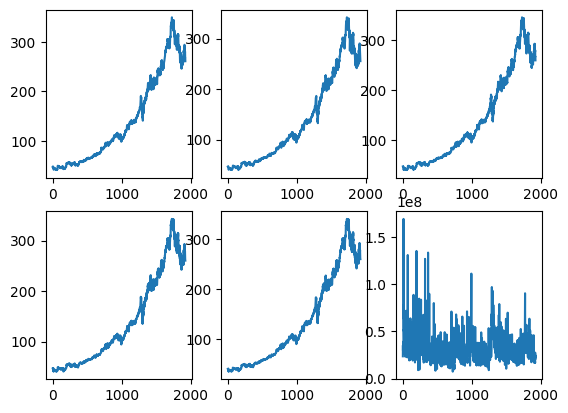

In [323]:
fig, axes = plt.subplots(nrows=2, ncols=3)

# Plot all time series to make sure data looks ok, that there are no wrongly imputed values or outliers etc..
data["High"].plot(ax=axes[0,0])
data["Low"].plot(ax=axes[0,1])
data["Open"].plot(ax=axes[0,2])
data["Close"].plot(ax=axes[1,0])
data["Adj Close"].plot(ax=axes[1,1])
data["Volume"].plot(ax=axes[1,2])

In [324]:
#Create Feature with number of days that the market has been closed, instead of Date
date = pd.to_datetime(data["Date"])
diff = (date - date.shift(1)).dt.days
diff[0] = 1.0
data["days_since_market_open"] = diff
data = data.drop(columns="Date")

#Create target variable, the change in market Open between two days
target = data["Open"] - data["Open"].shift(1)
#Set first target to 0, since there's no prior data for prediction
target.iloc[0] = 0

#Keep copy of original dataframe for reference
df_data = data.copy(deep=False)


C:\Users\c-lianer\AppData\Local\Temp\ipykernel_43060\1495525703.py:4: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  diff[0] = 1.0


In [325]:
def process_dataset(x, y, memory_len):
    """Function that creates a dataset, y_data contains the target variable (open price diff), and x_data contains a sequence of all features
      from memory len days to the day before that target variable"""
    x_data, y_data = list(), list()
    for i in range(len(data) - memory_len):
        x_data.append(x[i:(i+memory_len), :])
        y_data.append(y[i+memory_len])
    return np.asarray(x_data), np.asarray(y_data)

In [326]:
#Transform data by mean shifting and scaling
x_scaler = StandardScaler().fit(data)
target = np.asarray(target).reshape(-1,1)
y_scaler = StandardScaler().fit(target)
x = x_scaler.transform(data)
y = y_scaler.transform(target)
#Memory length of 10 seems reasonable, would a stock still have impact from an event more than 10 days ago?
memory_len = 10
X_data, Y_data = process_dataset(x, y, memory_len)

#Train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, shuffle = False, stratify = None)
#Validation and test split, now train = 70%, Test ~20%, Validate ~10%
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.7, shuffle=False, stratify=None)


In [331]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2]), dropout=0.3))
model.add(LSTM(32, return_sequences=False, dropout=0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

checkpoint_path = "training_1/cp.ckpt"

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                     save_weights_only=True,
                                     save_best_only=True,
                                     monitor = "val_loss",
                                     verbose=1)

history = model.fit(X_train, Y_train, batch_size=1, epochs=10, validation_data=(X_val, Y_val), callbacks=[cp_callback])


Epoch 1/10
1332/1340 [============================>.] - ETA: 0s - loss: 0.3820
Epoch 1: val_loss improved from inf to 1.86893, saving model to training_1\cp.ckpt
1340/1340 [==============================] - 9s 5ms/step - loss: 0.3827 - val_loss: 1.8689
Epoch 2/10
1330/1340 [============================>.] - ETA: 0s - loss: 0.3765
Epoch 2: val_loss improved from 1.86893 to 1.85766, saving model to training_1\cp.ckpt
1340/1340 [==============================] - 6s 5ms/step - loss: 0.3743 - val_loss: 1.8577
Epoch 3/10
1337/1340 [============================>.] - ETA: 0s - loss: 0.3753
Epoch 3: val_loss improved from 1.85766 to 1.85527, saving model to training_1\cp.ckpt
1340/1340 [==============================] - 6s 5ms/step - loss: 0.3746 - val_loss: 1.8553
Epoch 4/10
1340/1340 [==============================] - ETA: 0s - loss: 0.3717
Epoch 4: val_loss did not improve from 1.85527
1340/1340 [==============================] - 6s 5ms/step - loss: 0.3717 - val_loss: 1.8730
Epoch 5/10
1330/

In [332]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.load_weights(checkpoint_path)

predictions = model.predict(X_test)

13/13 [==============================] - 1s 6ms/step


Prediction difference RMSE: 0.002434951180475764


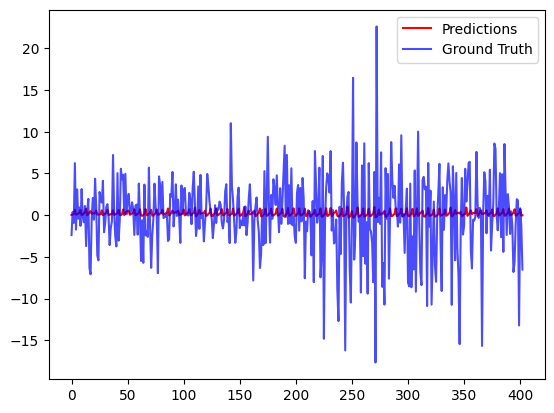

In [333]:
#This cell prints rmse of predictions, and plots them

predictions_rescaled =  y_scaler.inverse_transform(predictions)
Y_test_rescaled = y_scaler.inverse_transform(Y_test)

plt.plot(predictions_rescaled, color='r')
plt.plot(Y_test_rescaled, color='blue', alpha=0.7)
plt.legend(["Predictions", "Ground Truth"])

#Compute and print rmse of the difference between the prediction and true value, should be positive to earn money.
rmse_predictions = np.sqrt(np.mean((predictions_rescaled - Y_test_rescaled)**2))
rmse_target = np.sqrt(np.mean((Y_test_rescaled)**2))
target_diff = rmse_target - rmse_predictions
print("Prediction difference RMSE:", target_diff )

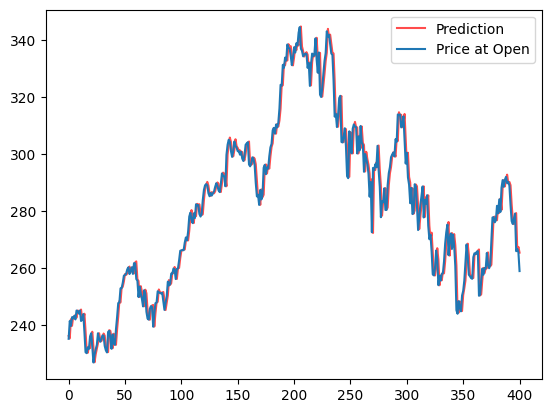

In [334]:
#Plot the prediction next to the ground truth

open_vals = np.asarray(df_data["Open"][memory_len:])

train_array, test_array = train_test_split(open_vals, test_size=0.3, shuffle = False, stratify = None)
val_array, test_array = train_test_split(test_array, test_size=0.7, shuffle=False, stratify=None)

open_prices_truth = np.roll(test_array, -1) #delay all open prices with one day
open_prices_predicted = test_array + predictions_rescaled.flatten()

#Plot, and skip first and last element because of the prediction shift
plt.plot(open_prices_predicted[1:-1], color='r', alpha=0.7)
plt.plot(open_prices_truth[1:-1])
plt.legend(["Prediction", "Price at Open"])